In [16]:
# Import packages
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt
import copy
from IPython.display import display
import json
from pathlib import Path
import sys
import seaborn as sns

2.b: Now we add an battery investment cost and a scaling factor, to finde the best investment over the 10 year lifetime of the battery

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 265 rows, 193 columns and 578 nonzeros
Model fingerprint: 0x89483c58
Coefficient statistics:
  Matrix range     [9e-01, 6e+00]
  Objective range  [2e+03, 2e+04]
  Bounds range     [3e+00, 1e+01]
  RHS range        [1e-01, 1e+03]
Presolve removed 97 rows and 10 columns
Presolve time: 0.01s
Presolved: 168 rows, 183 columns, 473 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.0259500e+07   6.247299e+03   0.000000e+00      0s
     140    1.0932535e+05   0.000000e+00   0.000000e+00      0s

Solved in 140 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.093253475e+05

Optimal s_bat: 0.000 (× baseline) → 0.00 kWh
Total cost (10 years): 10

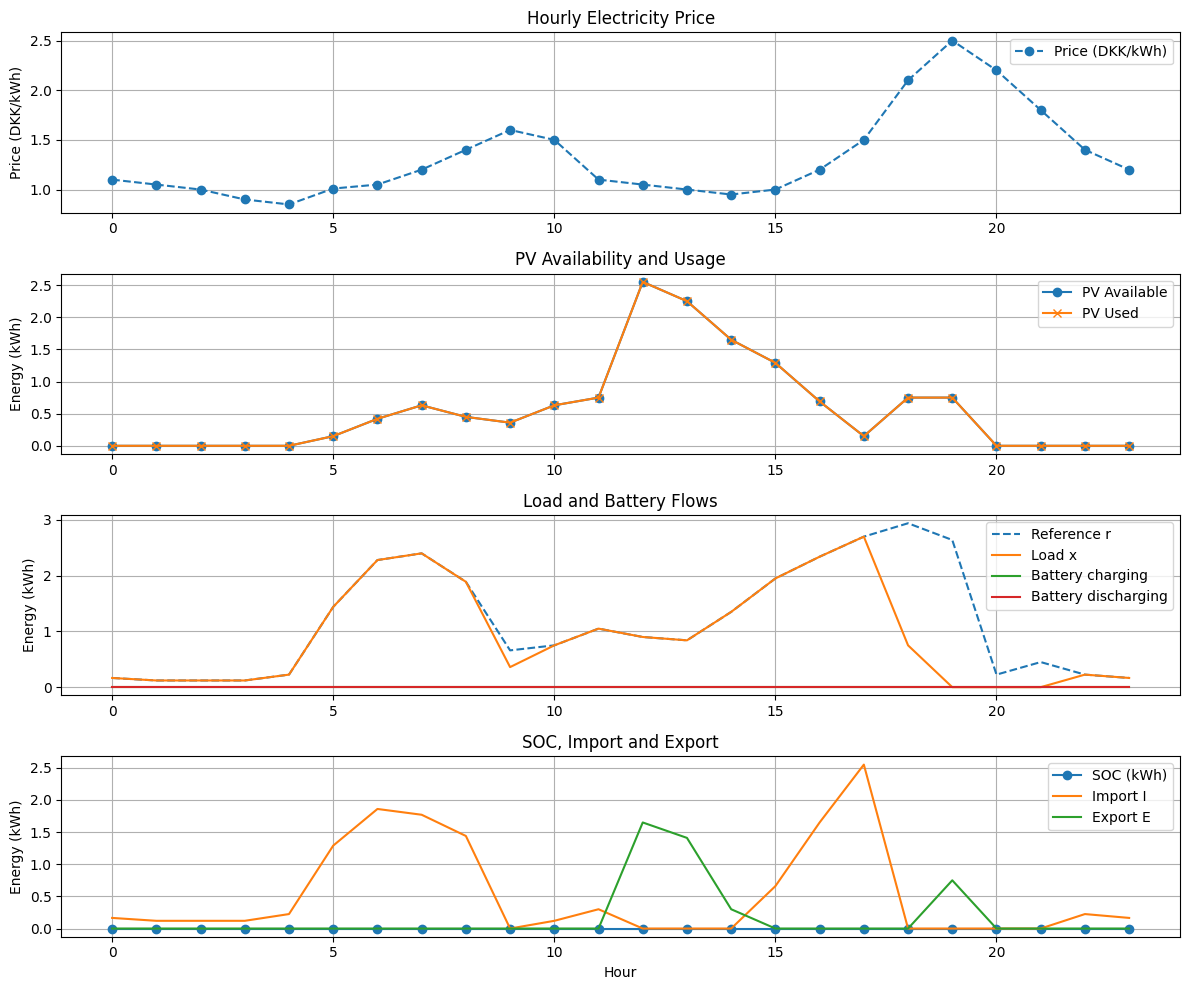

In [ ]:

USER_SETTINGS = {
    "investment_cost_DKK_per_kWh": 4000.0,   # CAPEX cost per kWh of capacity (source: https://www.solarchoice.net.au/solar-batteries/is-home-battery-storage-worth-it/)
    "s_bat_upper_bound": 10.0,                # Max scaling factor for battery (× baseline)
    "analysis_years": 10,                    # Battery lifetime in years
    "representative_days": 365,              # How many days 1 simulated day represents
}

# -------- Utils --------
def load_json(path: Path):
    if path.exists():
        return json.loads(path.read_text())
    return None

# -------- Paths --------
base_folder = Path("data/question_1c/")
appliance_path = base_folder / "appliance_params.json"
bus_path = base_folder / "bus_params.json"
consumer_path = base_folder / "consumer_params.json"
der_prod_path = base_folder / "DER_production.json"
usage_pref_path = base_folder / "usage_preferences.json"

appliance_params = load_json(appliance_path)
bus_params = load_json(bus_path)
consumer_params = load_json(consumer_path)
DER_production = load_json(der_prod_path)
usage_pref = load_json(usage_pref_path)

# Single consumer / bus assumption
consumer = consumer_params[0]
bus = bus_params[0]

# -------- Specs --------
pv_spec = appliance_params["DER"][0]
pv_max_kW = float(pv_spec["max_power_kW"])

load_spec = appliance_params["load"][0]
load_max_kWh = float(load_spec["max_load_kWh_per_hour"])

storage_spec = appliance_params["storage"][0]
storage_id = storage_spec["storage_id"]

# Baseline battery parameters
C0 = float(storage_spec["storage_capacity_kWh"])  # capacity [kWh]
max_charging_power_ratio = float(storage_spec["max_charging_power_ratio"])
max_discharging_power_ratio = float(storage_spec["max_discharging_power_ratio"])
eta_ch = float(storage_spec["charging_efficiency"])
eta_dis = float(storage_spec["discharging_efficiency"])
P_ch0 = max_charging_power_ratio * C0
P_dis0 = max_discharging_power_ratio * C0

# --- User override values (from USER_SETTINGS block) ---
c_inv = float(USER_SETTINGS["investment_cost_DKK_per_kWh"])
s_bat_ub = float(USER_SETTINGS["s_bat_upper_bound"])
L_years = int(USER_SETTINGS["analysis_years"])
N_rep = int(USER_SETTINGS["representative_days"])

# Storage prefs (SoC ratios)
storage_prefs = usage_pref[0].get("storage_preferences", [])
initial_soc_ratio = float(storage_prefs[0]["initial_soc_ratio"])
final_soc_ratio = float(storage_prefs[0]["final_soc_ratio"])

# Bus parameters
prices = bus["energy_price_DKK_per_kWh"]
if len(prices) != 24:
    raise SystemExit(f"Expected 24 hourly prices; got {len(prices)}")

import_tariff = float(bus["import_tariff_DKK/kWh"])
export_tariff = float(bus["export_tariff_DKK/kWh"])
max_import = float(bus["max_import_kW"])
max_export = float(bus["max_export_kW"])

der_profile = DER_production[0]["hourly_profile_ratio"]
if len(der_profile) != 24:
    raise SystemExit("Expected 24 hourly DER profile entries")
pv_avail = [pv_max_kW * float(r) for r in der_profile]

# Load reference profile
load_prefs = usage_pref[0].get("load_preferences", [])
if not load_prefs:
    raise SystemExit("No load_preferences found in usage_preferences.json")
lp0 = load_prefs[0]
hourly_profile_ratio = lp0.get("hourly_profile_ratio", None)
if hourly_profile_ratio is None or len(hourly_profile_ratio) != 24:
    raise SystemExit("Expected a 24-entry hourly_profile_ratio for the load")
r = [float(ratio) * load_max_kWh for ratio in hourly_profile_ratio]

# Discomfort penalty
gamma = 2.0
T = list(range(24))

# -------- Model --------
m = gp.Model("consumer_flex_lp_with_battery_investment")
m.setParam('OutputFlag', 1)

# Investment variable (battery scaling)
s_bat = m.addVar(lb=0.0, ub=s_bat_ub, name="s_bat")

# Operational variables
x = m.addVars(T, lb=0.0, ub=load_max_kWh, name="x")
u = m.addVars(T, lb=0.0, name="u")
I = m.addVars(T, lb=0.0, name="I")
E = m.addVars(T, lb=0.0, name="E")
d = m.addVars(T, lb=0.0, name="d")

# Battery variables
p_ch = m.addVars(T, lb=0.0, name="p_ch")
p_dis = m.addVars(T, lb=0.0, name="p_dis")
SOC = m.addVars(T, lb=0.0, name="SOC")

# PV availability
for t in T:
    m.addConstr(u[t] <= pv_avail[t], name=f"pv_cap_{t}")

# Import/export caps
for t in T:
    m.addConstr(I[t] <= max_import, name=f"import_cap_{t}")
    m.addConstr(E[t] <= max_export, name=f"export_cap_{t}")

# Energy balance
for t in T:
    m.addConstr(I[t] - E[t] + u[t] + p_dis[t] == x[t] + p_ch[t], name=f"balance_{t}")

# Deviation constraints
for t in T:
    m.addConstr(d[t] >= x[t] - r[t], name=f"dev_pos_{t}")
    m.addConstr(d[t] >= r[t] - x[t], name=f"dev_neg_{t}")

# Battery power limits
for t in T:
    m.addConstr(p_ch[t] <= s_bat * P_ch0,  name=f"p_ch_cap_{t}")
    m.addConstr(p_dis[t] <= s_bat * P_dis0, name=f"p_dis_cap_{t}")

# SoC dynamics
m.addConstr(
    SOC[0] == (initial_soc_ratio * s_bat * C0)
    + eta_ch * p_ch[0] - (1.0 / eta_dis) * p_dis[0],
    name="soc_0"
)
for t in T[1:]:
    m.addConstr(
        SOC[t] == SOC[t - 1] + eta_ch * p_ch[t] - (1.0 / eta_dis) * p_dis[t],
        name=f"soc_{t}"
    )

# SoC limits
for t in T:
    m.addConstr(SOC[t] >= 0.0, name=f"soc_min_{t}")
    m.addConstr(SOC[t] <= s_bat * C0, name=f"soc_max_{t}")

# Terminal SoC condition
m.addConstr(SOC[T[-1]] >= (final_soc_ratio * s_bat * C0), name="terminal_soc")

# Objective function (lifetime cost)
daily_oper_cost = gp.quicksum(
    (prices[t] + import_tariff) * I[t]
    - (prices[t] - export_tariff) * E[t]
    + gamma * d[t]
    for t in T
)
lifetime_oper_cost = L_years * N_rep * daily_oper_cost
investment_cost = c_inv * C0 * s_bat
m.setObjective(lifetime_oper_cost + investment_cost, GRB.MINIMIZE)

# -------- Solve --------
m.optimize()

if m.Status == GRB.OPTIMAL:
    # Results
    x_sol = [x[t].X for t in T]
    u_sol = [u[t].X for t in T]
    I_sol = [I[t].X for t in T]
    E_sol = [E[t].X for t in T]
    d_sol = [d[t].X for t in T]
    p_ch_sol = [p_ch[t].X for t in T]
    p_dis_sol = [p_dis[t].X for t in T]
    SOC_sol = [SOC[t].X for t in T]

    print(f"\nOptimal s_bat: {s_bat.X:.3f} (× baseline) → {s_bat.X * C0:.2f} kWh")

    objective_value = m.ObjVal
    print(f"Total cost (10 years): {objective_value:.2f} DKK")
    print(f"Investment cost: {c_inv * C0 * s_bat.X:.2f} DKK")

    # ---- Plot ----
    plt.figure(figsize=(12, 10))
    plt.subplot(4, 1, 1)
    plt.plot(T, prices, label="Price (DKK/kWh)", linestyle='--', marker='o')
    plt.ylabel("Price (DKK/kWh)")
    plt.title("Hourly Electricity Price")
    plt.grid()
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(T, pv_avail, label="PV Available", marker='o')
    plt.plot(T, u_sol, label="PV Used", marker='x')
    plt.ylabel("Energy (kWh)")
    plt.title("PV Availability and Usage")
    plt.grid()
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(T, r, label="Reference r", linestyle='--')
    plt.plot(T, x_sol, label="Load x")
    plt.plot(T, p_ch_sol, label="Battery charging")
    plt.plot(T, p_dis_sol, label="Battery discharging")
    plt.ylabel("Energy (kWh)")
    plt.title("Load and Battery Flows")
    plt.grid()
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(T, SOC_sol, label="SOC (kWh)", marker='o')
    plt.plot(T, I_sol, label="Import I")
    plt.plot(T, E_sol, label="Export E")
    plt.xlabel("Hour")
    plt.ylabel("Energy (kWh)")
    plt.title("SOC, Import and Export")
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Model not solved to optimality. Status:", m.Status)
